# training_+ttbarModel.ipynb

This is code (in progress) for building and training the neural network.

## Imports

In [34]:
import sys
sys.path.append("/home/jchishol/TRecNet")
sys.path.append("home/jchishol/")

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Input, concatenate, Masking, LSTM, TimeDistributed, Lambda, Reshape, Multiply, BatchNormalization, Bidirectional
from tensorflow.keras import regularizers 
from tensorflow.keras import initializers
from sklearn.model_selection import train_test_split
import h5py 
import os 
from clr_callback import *
from tensorflow.keras.callbacks import TensorBoard
import tensorflow.keras.backend as K  
from tensorflow.keras.optimizers import * 
from IPython.display import clear_output
# import keras_one_cycle_clr as ktool
import importlib
os.environ["CUDA_VISIBLE_DEVICES"]="0"
%matplotlib inline 

from training_utilities import PlotLearning


import normalize
import shape_timesteps
import analysis

## Loading Files

In [2]:
# Data type we want to use
data_type = 'variables_ttbar_ljets_jetMatch04_6jets_train'

# Dataset to train and test on
dataset = h5py.File('/data/jchishol/ML_Data/'+data_type+'.h5','r')

# Numpy array of [max,mean] for each variable
X_maxmean_dic = np.load('../X_maxmean_'+data_type+'.npy',allow_pickle=True).item()
Y_maxmean_dic = np.load('../Y_maxmean_'+data_type+'.npy',allow_pickle=True).item()

## Useful Variables

In [3]:
# X and Y variables to be used
X_keys = ['j1_pt', 'j1_eta', 'j1_phi', 'j1_m', 'j1_isbtag', 'j2_pt', 'j2_eta', 'j2_phi', 'j2_m', 'j2_isbtag', 'j3_pt', 'j3_eta', 'j3_phi', 'j3_m', 'j3_isbtag', 'j4_pt', 'j4_eta', 'j4_phi', 'j4_m', 'j4_isbtag', 'j5_pt', 'j5_eta', 'j5_phi', 'j5_m', 'j5_isbtag', 'j6_pt', 'j6_eta', 'j6_phi', 'j6_m', 'j6_isbtag', 'lep_pt', 'lep_eta', 'lep_phi', 'met_met', 'met_phi']
Y_keys = ['th_pt', 'th_eta','th_phi','th_m', 'wh_pt', 'wh_eta', 'wh_phi', 'wh_m', 'tl_pt', 'tl_eta', 'tl_phi', 'tl_m', 'wl_pt', 'wl_eta', 'wl_phi', 'wl_m','ttbar_pt','ttbar_eta','ttbar_phi','ttbar_m']
Y_length = len(Y_keys)
X_length = len(X_keys)

# Variables keys, needed for helper codes
phi_keys = list(filter(lambda a: 'phi' in a, dataset.keys()))
eta_keys = list(filter(lambda a: 'eta' in a, dataset.keys()))
pt_keys =  list(filter(lambda a: 'pt' in a, dataset.keys()))
m_keys = list(filter(lambda a: 'm' in a, dataset.keys()))
isbtag_keys = list(filter(lambda a: 'isbtag' in a, dataset.keys()))

# Number of events in the dataset
size = np.array(dataset.get('th_pt')).size
crop0 = size    # Used in helper codes

# Get the maxmean values we actually need for this particular model
xmm_keys = list(X_maxmean_dic.keys())
ymm_keys = [key for key in Y_maxmean_dic.keys() if 'isTruth' not in key]
X_maxmean = np.array([X_maxmean_dic[key] for key in xmm_keys])
Y_maxmean = np.array([Y_maxmean_dic[key] for key in ymm_keys])

print(crop0)

5623632


## Scale the Data

In [4]:
# Scales data set to be between -1 and 1, with a mean of 0
importlib.reload(normalize)    # Need to reload so it recognizes the variables we just defined
Scaler = normalize.Scale_variables()
X_total, X_names = Scaler.scale_arrays(X_keys, X_maxmean)
Y_total, Y_names = Scaler.scale_arrays(Y_keys, Y_maxmean)

## Split Data Into Training, Validation, and Testing

In [5]:
# Set how the data will be split (70 for training, 15 for validation, 15 for testing)
# Taking ~82% for training and ~18% for validation amounts to ~70% of total being training and ~15% of total being validation
split = 0.82

# Split up jets and other for X
timestep_builder = shape_timesteps.Shape_timesteps()
totalX_jets, totalX_other = timestep_builder.reshape_X(X_total, X_names, False,True)

# Split into training and validation data
trainX_jets, valX_jets, trainX_other, valX_other, trainY, valY = train_test_split(totalX_jets, totalX_other, Y_total, train_size=split)

print(trainY.shape)

(4611378, 25)


## Histograms of Scaled Input X and Y Variables

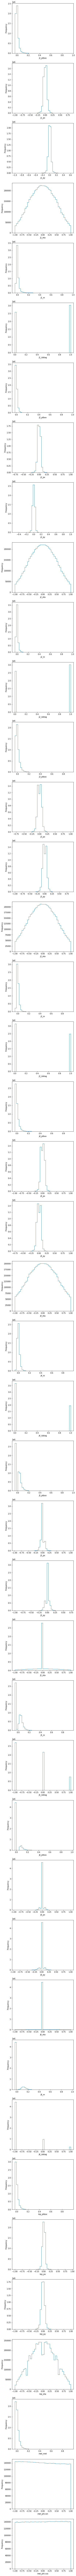

In [6]:
# Define whether or not to plot
show = True

# Plot histograms
if show:
    plt.figure(figsize=(6,6*X_total.shape[1]))
    for i in range(0, X_total.shape[1]):
        plt.subplot(X_total.shape[1], 1, i+1)
        plt.hist(X_total[:,i], 40, histtype='step')
        plt.xlabel(X_names[i])
        plt.ylabel('Frequency')

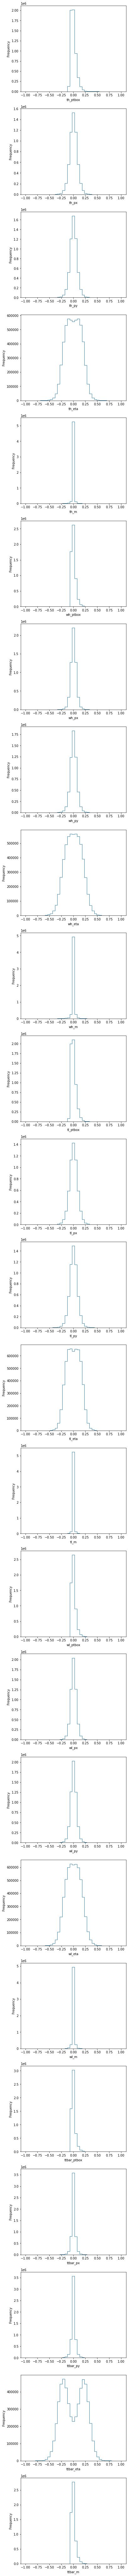

In [7]:
# Define whether or not to plot
show = True

# Define bins for different variables
other_bins = np.linspace(-1, 1, 40)
phi_bins = np.linspace(-1, 1, 40)
pt_bins = np.linspace(-1, 1, 40)
Y_bins = [phi_bins if 'phi' in name else pt_bins if 'pt' in name else other_bins for name in Y_names]

# Plot histograms
if show:
    plt.figure(figsize=(6,6*trainY.shape[1]))
    for i in range(0, trainY.shape[1]):
        plt.subplot(trainY.shape[1], 1, i+1)
        bins = Y_bins[i]
        plt.hist(Y_total[:,i], bins, histtype='step')
        plt.xlabel(Y_names[i])
        plt.ylabel('Frequency')

## Build the Model

In [8]:
def build_model():
    jet_input = Input(shape=(trainX_jets.shape[1], trainX_jets.shape[2]))
    Mask = Masking(-2)(jet_input)
    Maskshape = Reshape((trainX_jets.shape[1], trainX_jets.shape[2]))(Mask)
    other_input = Input(shape=(trainX_other.shape[1]))
    flat_jets =  Flatten()(jet_input)
    concat0 = concatenate([other_input, flat_jets])
    PreDense1 = Dense(256, activation='relu')(concat0)
    PreDense2 = Dense(256, activation='relu')(PreDense1)
    PreDense3 = Dense(trainX_jets.shape[1], activation='sigmoid')(PreDense2)
    Shape_Dot = Reshape((-1,1))(PreDense3)
    
    TDDense11 = TimeDistributed(Dense(128, activation='relu'))(Maskshape)
    TDDense12 = TimeDistributed(Dense(64, activation='relu'))(TDDense11)
    Dot_jets = Multiply()([Shape_Dot, TDDense12])
    TDDense13 = TimeDistributed(Dense(256, activation='relu'))(Dot_jets)
    TDDense14= TimeDistributed(Dense(256, activation='relu'))(TDDense13)
    flat_right = Flatten()(TDDense14)
    
    Dense21 = Dense(128, activation='relu')(other_input)
    Dense22 = Dense(64, activation='relu')(Dense21)
    flat_other = Flatten()(Dense22)
    
    concat = concatenate([flat_other, flat_right])
    
    ldense1 = Dense(256, activation='relu')(concat)
    ldense2 = Dense(128, activation='relu')(ldense1)
    loutput = Dense(10)(ldense2)   # 10 leptonic variable outputs
    
    hconcat = concatenate([loutput, concat])
    hdense1 = Dense(256, activation='relu')(hconcat)
    hdense2 = Dense(128, activation='relu')(hdense1)
    houtput = Dense(10+5)(hdense2)  # 10 hadronic variable outputs + 5 ttbar variable outputs
    
    output = concatenate([houtput, loutput])
    
    model = keras.models.Model(inputs=[jet_input, other_input], outputs=output)
    
    # Define loss function (do we even end up using this??)
    #def loss_fc(true, pred):
    #    return K.mean(K.square(true-pred)*(1+3*K.square(K.abs(true))))
    
    # lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-3, decay_steps=5000,decay_rate=0.6)
    lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(initial_learning_rate=1e-3, decay_steps=10000,end_learning_rate=5e-5,power=0.25)
    optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
    model.compile(loss='mae', optimizer= optimizer, metrics=['mse'])
    
    return model 

# Define loss function (again?)
#def loss_fc(true, pred):
#        return K.mean(K.square(true-pred)*(1+3*K.square(K.abs(true))))
    
# Load or build model
#model = keras.models.load_model('new_model.keras', custom_objects={'loss_fc':loss_fc})
model = build_model()
model.summary()
keras.utils.plot_model(model,to_file='Model_Custom+ttbar.png',show_shapes=True,show_dtype=True,show_layer_names=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 6, 6)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 7)]          0           []                               
                                                                                                  
 flatten (Flatten)              (None, 36)           0           ['input_1[0][0]']                
                                                                                                  
 concatenate (Concatenate)      (None, 43)           0           ['input_2[0][0]',                
                                                                  'flatten[0][0]']            

2022-08-29 11:01:21.763907: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-10.1/lib64
2022-08-29 11:01:21.763937: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-08-29 11:01:21.764271: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compi

## Fit the Model 

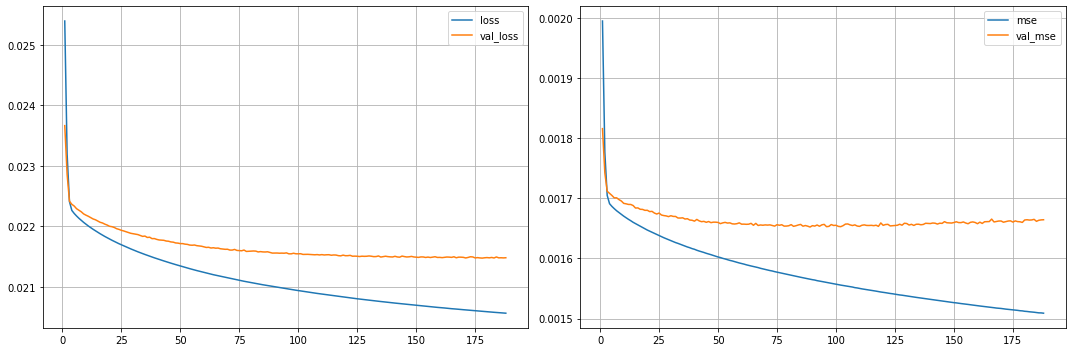

4612/4612 [==============================] - 74s 16ms/step - loss: 0.0206 - mse: 0.0015 - val_loss: 0.0215 - val_mse: 0.0017


In [8]:
# Set when to stop (has to do with loss?)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)  # patience=4 means stop training after 4 epochs with no improvement
#clr_triangular = CyclicLR(base_lr=1e-5, max_lr=1e-4, step_size=5000, mode='exp_range',gamma=0.9999) # don't think we use?
# class_weight = {0:2, 1:1, 2:1, 3:1, 4:1, 5:2, 6:1, 7:1, 8:1, 9:1, 10:2, 11:1, 12:1, 13:1, 14:1, 15:2, 16:1, 17:1, 18:1, 19:1}

# Set number of epochs (runs through?)
Epochs= 256


# Fit the model (i.e. TRAIN the model)
history = model.fit([trainX_jets, trainX_other], trainY, verbose=1, epochs=Epochs,
                   validation_data=([valX_jets, valX_other], valY), shuffle=True, callbacks=[early_stop,PlotLearning()],
                    batch_size=1000)
#history = model.fit([totalX_jets, totalX_other], Y_total, verbose=1, epochs=Epochs,
#                   validation_split=0.1, shuffle=True, callbacks=[early_stop],
#                    batch_size=1000)

## Save the Model

In [9]:
model.save('Model_Custom+ttbar_new.keras')


In [10]:
np.save('trainHistory_Model_Custom+ttbar_new.npy',history.history)

In [9]:
model = keras.models.load_model('Model_Custom+ttbar_new.keras')
history = np.load('trainHistory_Model_Custom+ttbar_new.npy',allow_pickle='TRUE').item()

## Plot Training Stats 

In [ ]:
#plt.xlabel('Training Iterations')
#plt.ylabel('Learning Rate')
#plt.title("CLR - 'triangular' Policy")
#plt.plot(clr_triangular.history['iterations'], clr_triangular.history['lr'])

Text(0.5, 1.0, 'TRecNet+ttbar MSE Loss')

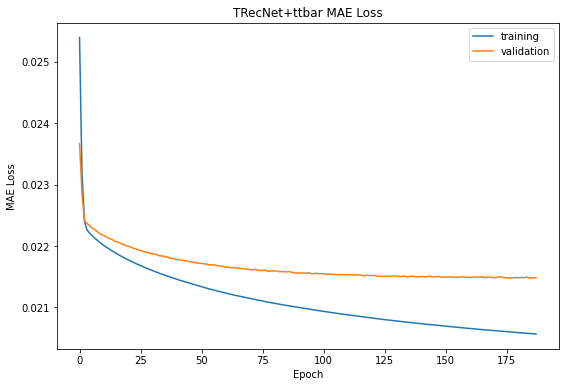

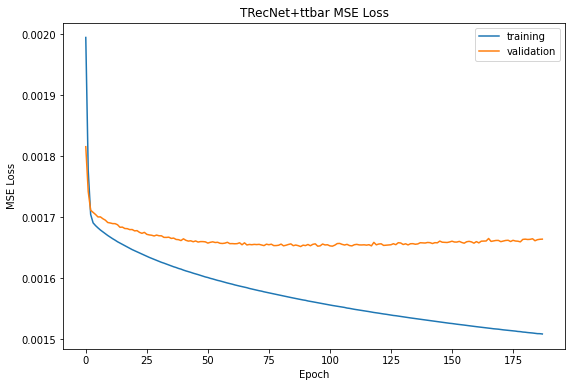

In [10]:
plt.figure(figsize=(9,6))
plt.plot(history['loss'], label='training')
plt.plot(history['val_loss'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('MAE Loss')
plt.legend()
plt.title('TRecNet+ttbar MAE Loss')

plt.figure(figsize=(9,6))
plt.plot(history['mse'], label='training')
plt.plot(history['val_mse'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.title('TRecNet+ttbar MSE Loss')



# Testing and Plots

This part of the code tests the machine learning and data.

## Make Predictions with Test Data

In [11]:
# Predict using un-scaled variables
predictions_unscaled = model.predict([valX_jets, valX_other])
true_unscaled = valY 

# Unscale the scaled predictions
predictions_origscale = Scaler.invscale_arrays(predictions_unscaled, Y_names, Y_maxmean)
true_origscale = Scaler.invscale_arrays(true_unscaled, Y_names, Y_maxmean)

## Training Scale Plots (Tao's Code)

In [38]:
Analysis = analysis.Analysis
Analysis.display_errors(predictions_unscaled, true_unscaled, Y_names, False)

total MSE: 0.0015348819593954894
 
th_ptbox MSE, MAE :  0.0006485344 0.0173233006
th_px MSE, MAE :  0.0013362285 0.0219656665
th_py MSE, MAE :  0.0010905706 0.0200272756
th_eta MSE, MAE :  0.0048539526 0.0386386255
th_m MSE, MAE :  0.0005913482 0.0087038358
wh_ptbox MSE, MAE :  0.0005991697 0.0155698611
wh_px MSE, MAE :  0.0008189117 0.0170587280
wh_py MSE, MAE :  0.0012088392 0.0208068613
wh_eta MSE, MAE :  0.0072755287 0.0478483977
wh_m MSE, MAE :  0.0010258693 0.0139819241
tl_ptbox MSE, MAE :  0.0004120654 0.0144302181
tl_px MSE, MAE :  0.0007485082 0.0182434027
tl_py MSE, MAE :  0.0007006641 0.0177232567
tl_eta MSE, MAE :  0.0026247452 0.0334683264
tl_m MSE, MAE :  0.0006056849 0.0087570783
wl_ptbox MSE, MAE :  0.0002652739 0.0118887933
wl_px MSE, MAE :  0.0002655113 0.0120213509
wl_py MSE, MAE :  0.0002757561 0.0122594081
wl_eta MSE, MAE :  0.0036327410 0.0425600974
wl_m MSE, MAE :  0.0009956073 0.0138498844
ttbar_ptbox MSE, MAE :  0.0003332525 0.0122197102
ttbar_px MSE, MAE :  0.

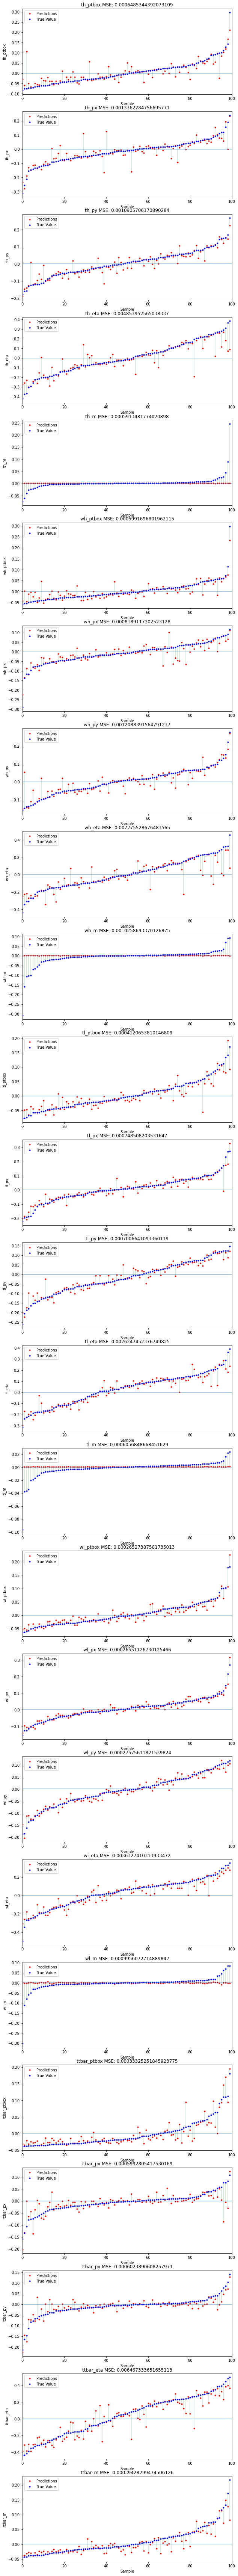

In [14]:
Analysis.predictions_vs_sample(predictions_unscaled, true_unscaled, Y_names, False)  # I think this is plotting the first 100 events? As like a sample

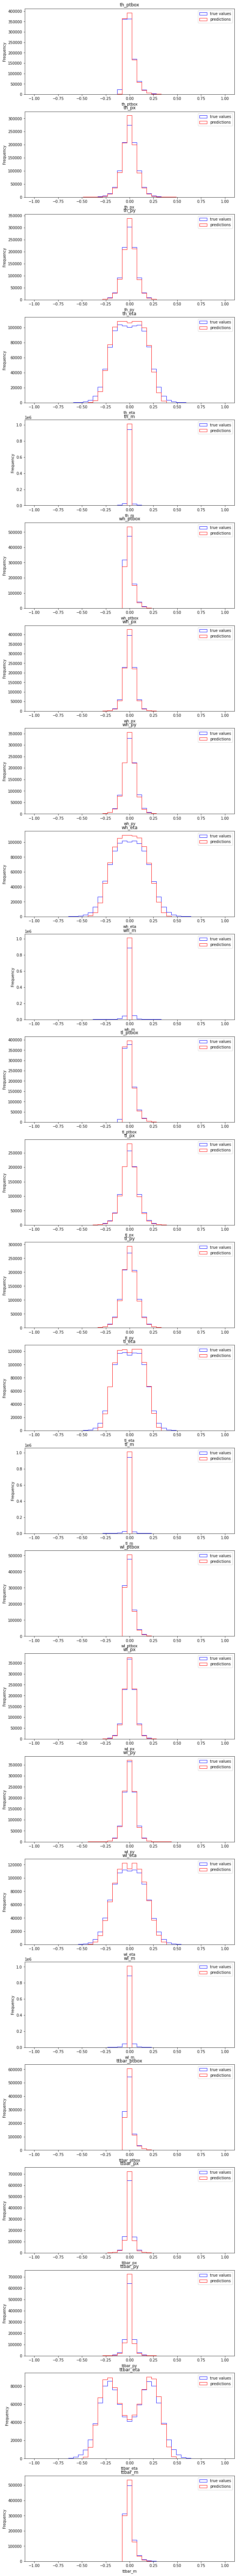

In [15]:
# Define bins for different variables
other_bins = np.linspace(-1, 1, 40)
phi_bins = np.linspace(-1, 1, 40)
pt_bins = np.linspace(-1, 1, 40)
Y_bins = [phi_bins if 'phi' in name else pt_bins if 'pt' in name else other_bins for name in Y_names]

Analysis.variable_histogram(predictions_unscaled, true_unscaled, Y_names, False, Y_bins)

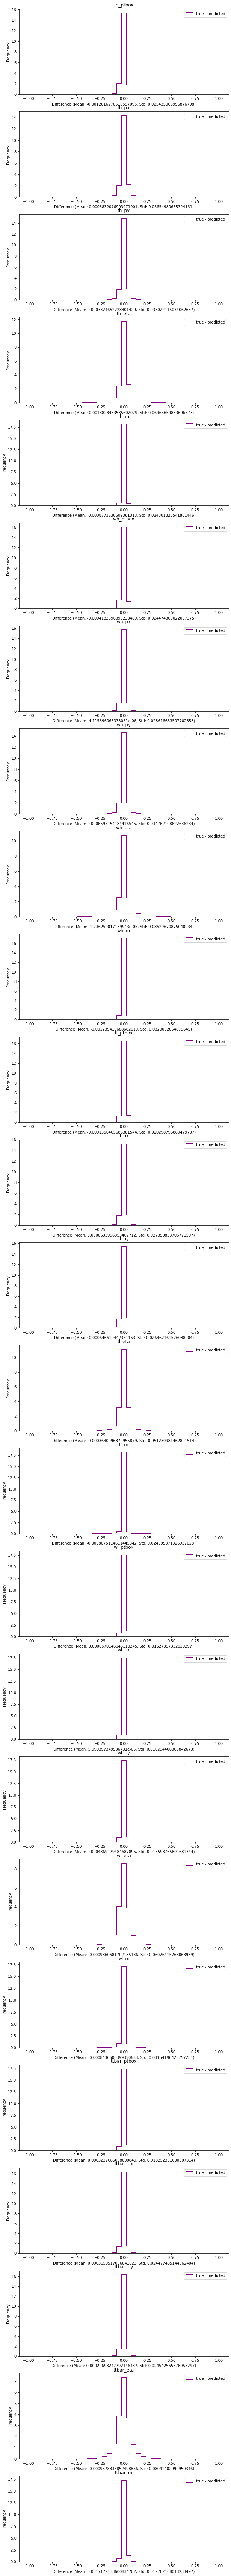

In [16]:
Analysis.difference_histogram(predictions_unscaled, true_unscaled, Y_names, False, Y_bins)

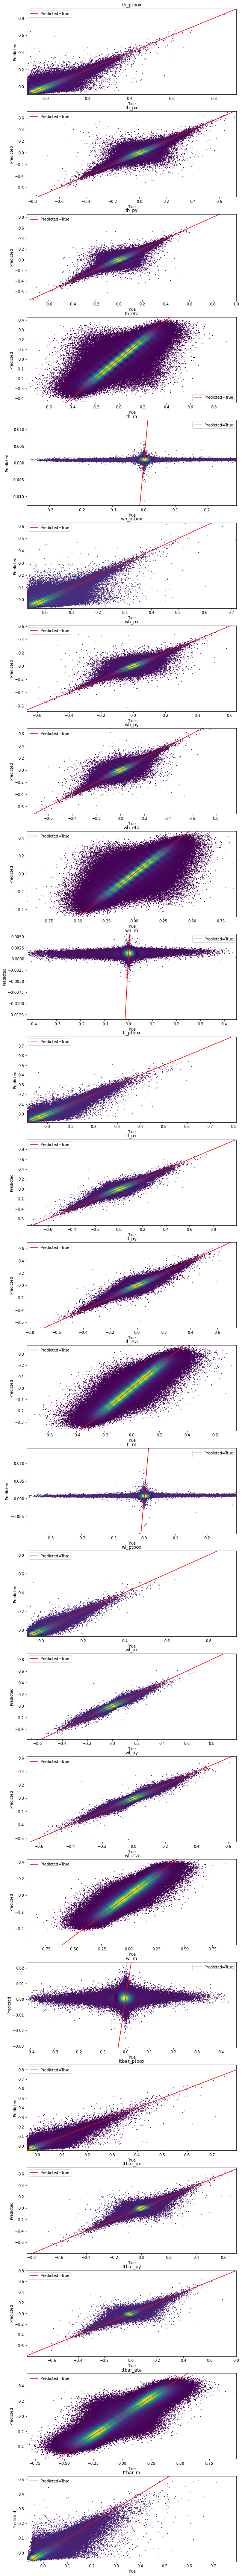

In [17]:
Analysis.predicted_vs_true(predictions_unscaled, true_unscaled, Y_names, False)

## Original Scale Plots

In [18]:
Analysis.display_errors(predictions_origscale, true_origscale, Y_keys, True)

total MSE: 662.9948809631022
 
th_pt MSE, MAE :  1703.3068227835 28.0744051167
th_eta MSE, MAE :  0.4236319747 0.3609676406
th_phi MSE, MAE :  0.6327413289 0.4314834087
th_m MSE, MAE :  35.1921362781 2.1233025130
wh_pt MSE, MAE :  1281.7472731496 22.7725164350
wh_eta MSE, MAE :  0.4933286085 0.3940063952
wh_phi MSE, MAE :  0.6152015968 0.4383380661
wh_m MSE, MAE :  36.0598373076 2.6213969924
tl_pt MSE, MAE :  1219.9706350917 24.8293024021
tl_eta MSE, MAE :  0.2899463136 0.3517622362
tl_phi MSE, MAE :  0.3866626744 0.3251242197
tl_m MSE, MAE :  36.0456464290 2.1363001922
wl_pt MSE, MAE :  633.6851448848 18.3749978553
wl_eta MSE, MAE :  0.2877468641 0.3787831867
wl_phi MSE, MAE :  0.1887887062 0.2440000274
wl_m MSE, MAE :  36.9941403758 2.6697376669
ttbar_pt MSE, MAE :  1451.0031342605 25.4981318769
ttbar_eta MSE, MAE :  0.8126251070 0.6180895951
ttbar_phi MSE, MAE :  1.1909883414 0.7416234069
ttbar_m MSE, MAE :  6812.8194039070 52.3130885498


In [30]:
importlib.reload(analysis)
analysis.Analysis.save_errors(predictions_origscale,true_origscale,Y_keys,True,'Model_Custom+ttbar_Errors')

In [31]:
e = np.load('Model_Custom+ttbar_Errors.npy',allow_pickle=True).item()
print(e)

{'th_pt': {'mse': 1703.306822783531, 'mae': 28.07440511666368}, 'th_eta': {'mse': 0.4236319747273935, 'mae': 0.3609676406030138}, 'th_phi': {'mse': 0.6327413288704722, 'mae': 0.4314834087383409}, 'th_m': {'mse': 35.19213627805338, 'mae': 2.1233025130404988}, 'wh_pt': {'mse': 1281.7472731496457, 'mae': 22.772516435046477}, 'wh_eta': {'mse': 0.4933286085198497, 'mae': 0.394006395181886}, 'wh_phi': {'mse': 0.6152015968282657, 'mae': 0.4383380660623445}, 'wh_m': {'mse': 36.059837307587415, 'mae': 2.621396992430954}, 'tl_pt': {'mse': 1219.9706350916601, 'mae': 24.8293024021394}, 'tl_eta': {'mse': 0.28994631364990325, 'mae': 0.3517622362186617}, 'tl_phi': {'mse': 0.3866626743528701, 'mae': 0.325124219680396}, 'tl_m': {'mse': 36.04564642895931, 'mae': 2.136300192217576}, 'wl_pt': {'mse': 633.68514488476, 'mae': 18.37499785529198}, 'wl_eta': {'mse': 0.28774686407849454, 'mae': 0.37878318673330247}, 'wl_phi': {'mse': 0.18878870620381943, 'mae': 0.24400002743566074}, 'wl_m': {'mse': 36.994140375

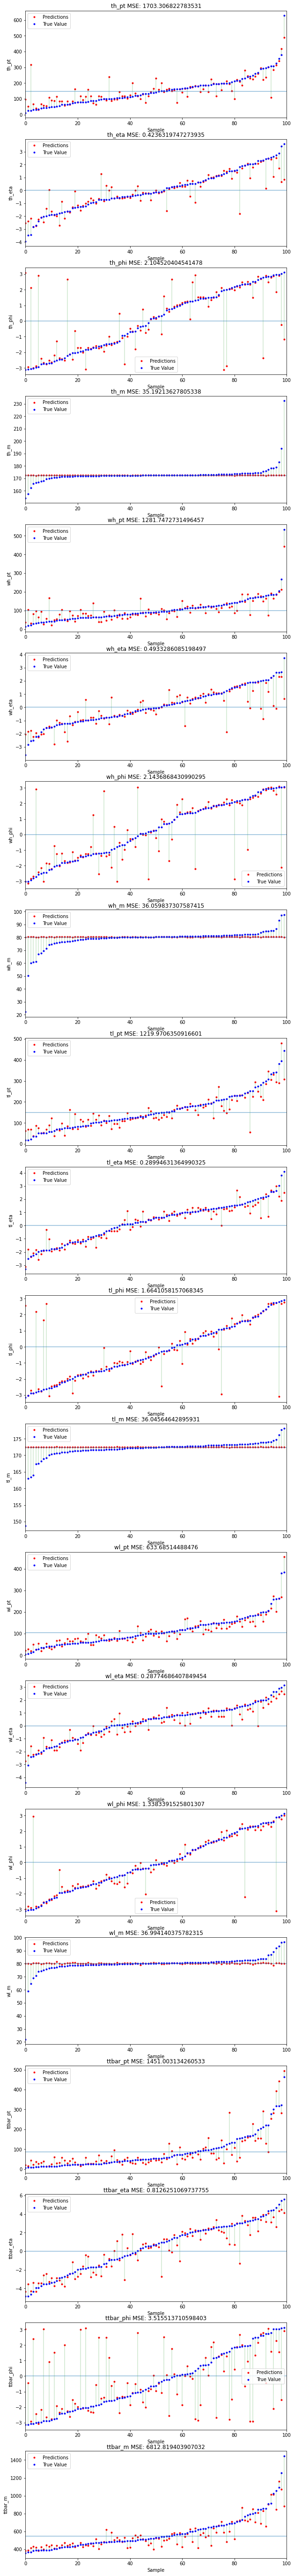

In [39]:
Analysis.predictions_vs_sample(predictions_origscale, true_origscale, Y_keys, True)

In [42]:
Analysis.variable_historam(predictions_origscale, true_origscale, Y_keys, True, [None for name in Y_names])

AttributeError: type object 'Analysis' has no attribute 'variable_historam'

/home/jchishol/myVenv/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


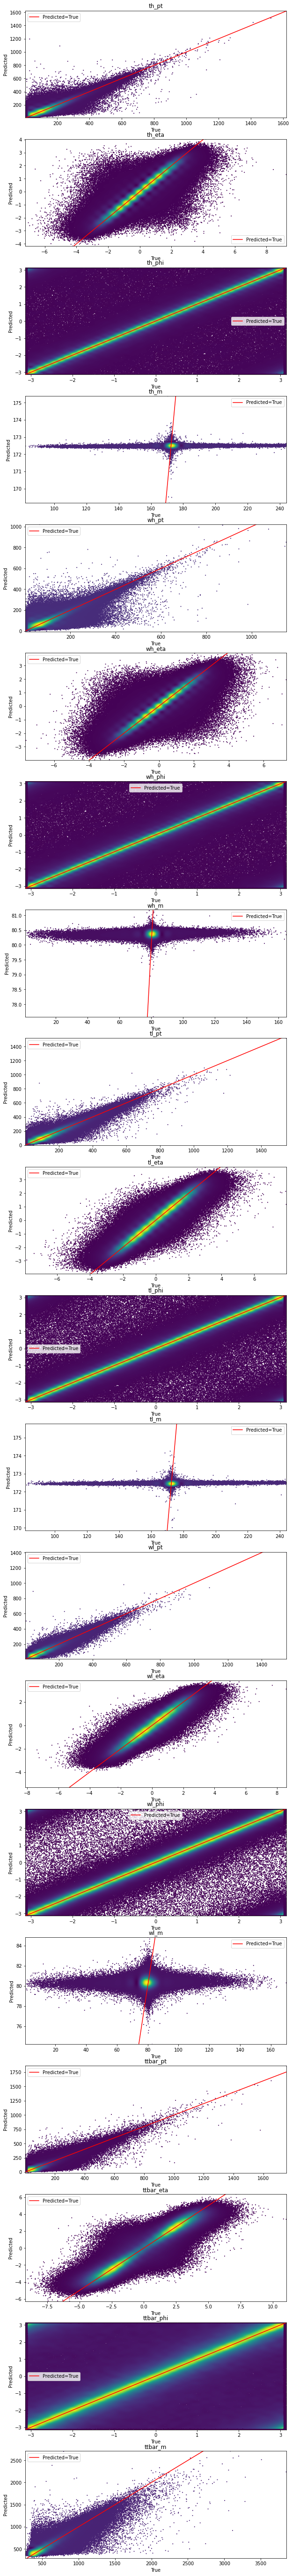

In [41]:
Analysis.predicted_vs_true(predictions_origscale, true_origscale, Y_keys, True)

## Observables

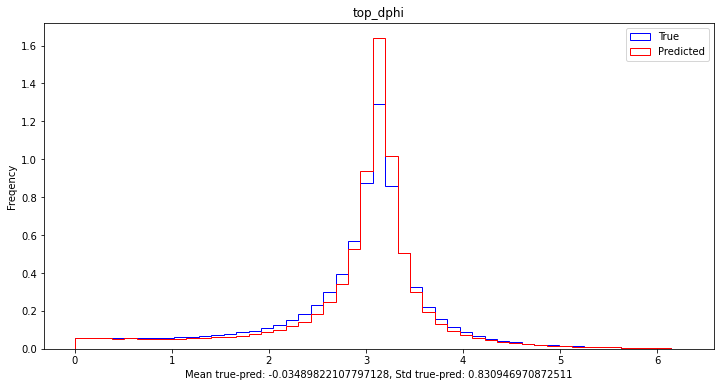

In [43]:
import observables 
import importlib
importlib.reload(observables)
truths = observables.fill_observables(true_origscale, True, Y_keys)
preds = observables.fill_observables(predictions_origscale, False, Y_keys)

# top_dphi=np.abs(th_phi-tl_phi)
plt.figure(figsize=(12,6))
observables.plot_hist(truths['top_dphi'], preds['top_dphi'])

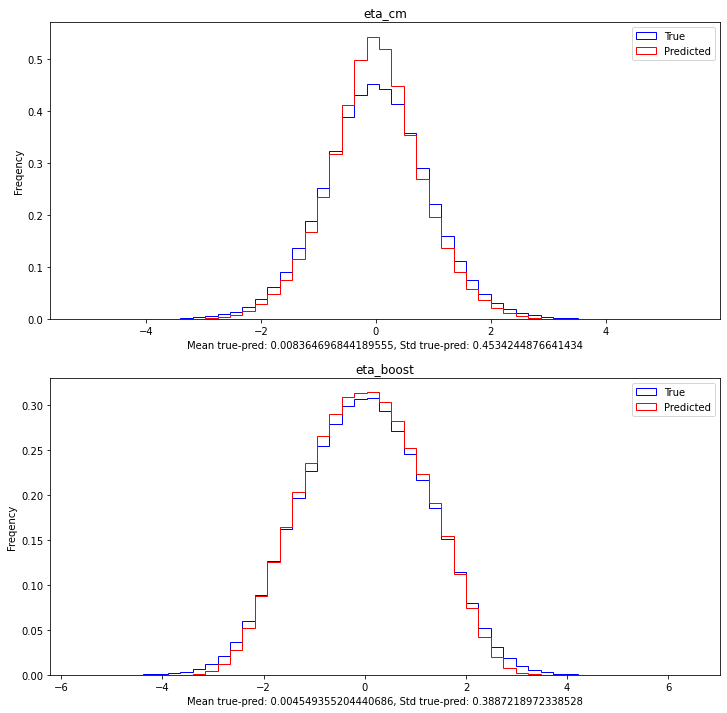

In [44]:
# eta_cm=0.5*(th_eta-tl_eta), eta_boost=0.5*(th_eta+tl_eta)
plt.figure(figsize=(12,12))
plt.subplot(211)
observables.plot_hist(truths['eta_cm'], preds['eta_cm'])
plt.subplot(212)
observables.plot_hist(truths['eta_boost'], preds['eta_boost'])

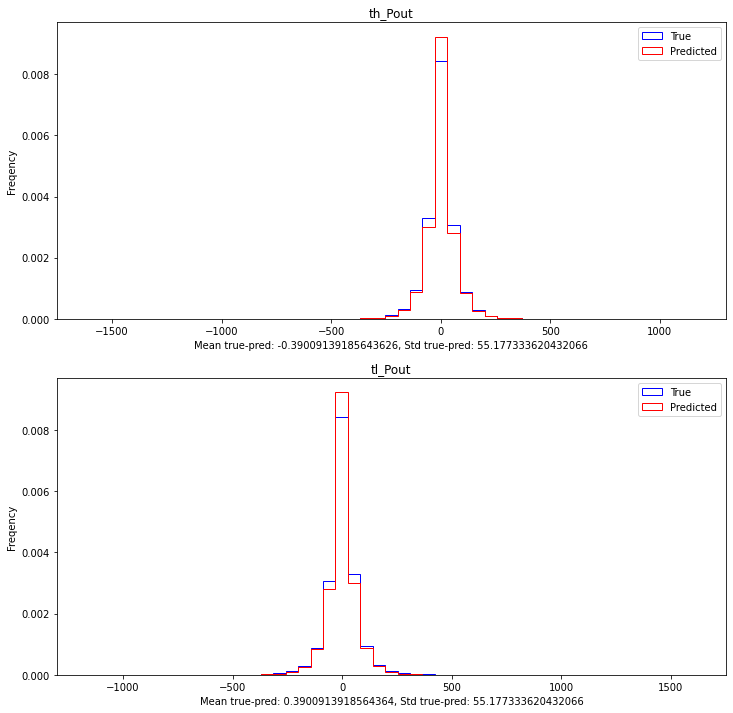

In [45]:
# th_Pout=dot(th_P, cross(tl_P,ez)/norm(tl_P,ez)), tl_Pout=dot(tl_P, cross(th_P,ez)/norm(th_P,ez))
plt.figure(figsize=(12,12))
plt.subplot(211)
observables.plot_hist(truths['th_Pout'], preds['th_Pout'])
plt.subplot(212)
observables.plot_hist(truths['tl_Pout'], preds['tl_Pout'])

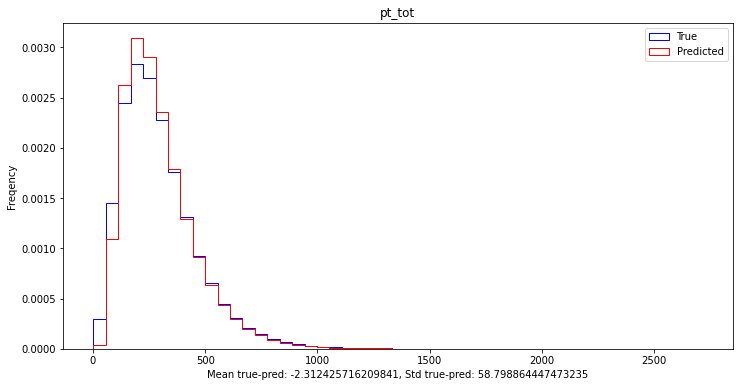

In [46]:
# pt_tot = th_pt+tl_pt
plt.figure(figsize=(12,6))
observables.plot_hist(truths['pt_tot'],preds['pt_tot'])